<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ViLT/ViLT_for_natural_language_visual_reasoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViLT for natural language visual reasoning

In this notebook, we are going to illustrate `ViltForImagesAndTextClassification`, a model that can be used for [NLVRv2](https://lil.nlp.cornell.edu/nlvr/), an important benchmark regarding the combination of natural language and vision.

Given a pair of images, the model must decide whether a sentence is true or false.

* ViLT docs: https://huggingface.co/docs/transformers/master/en/model_doc/vilt 

## Set-up environment

First, we install HuggingFace Transformers as well as datasets.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 8.0 MB/s 
     |████████████████████████████████| 895 kB 54.3 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
     |████████████████████████████████| 6.8 MB 56.2 MB/s 


In [2]:
!pip install -q datasets

     |████████████████████████████████| 306 kB 7.4 MB/s 
     |████████████████████████████████| 133 kB 74.7 MB/s 
     |████████████████████████████████| 1.1 MB 70.7 MB/s 
     |████████████████████████████████| 243 kB 75.8 MB/s 
     |████████████████████████████████| 160 kB 71.7 MB/s 
     |████████████████████████████████| 271 kB 76.2 MB/s 
     |████████████████████████████████| 144 kB 71.9 MB/s 


## Prepare image pair + sentence

Here we take 2 images (of the NLVR2 dataset) and create a corresponding sentence.

The model needs to predict whether the sentence is true or false.

Downloading:   0%|          | 0.00/2.66k [00:00<?, ?B/s]

No config specified, defaulting to: fixtures_nlvr2/image


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/32.2k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

Dataset fixtures_nlvr2 downloaded and prepared to /root/.cache/huggingface/datasets/hf-internal-testing___fixtures_nlvr2/image/1.9.0/3e0b88047c602150214bb5f4c364a2f46ec4bdd6b3ee44d08864f1c79170c6e8. Subsequent calls will reuse this data.


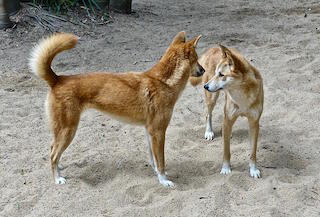

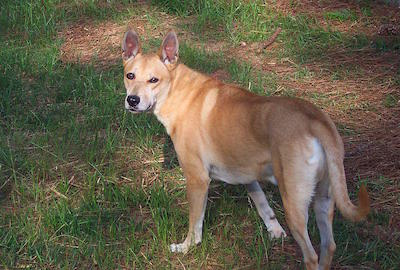

In [3]:
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("hf-internal-testing/fixtures_nlvr2", split="test")
image1 = Image.open(dataset[0]["file"]).convert("RGB")
image2 = Image.open(dataset[1]["file"]).convert("RGB")
display(image1)
display(image2)

In [4]:
text = "The left image contains twice the number of dogs as the right image, and at least two dogs in total are standing."

In [5]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

Downloading:   0%|          | 0.00/251 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

Let's prepare them for the model:

In [6]:
encoding = processor([image1, image2], text, return_tensors="pt")

In [7]:
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([1, 26])
token_type_ids torch.Size([1, 26])
attention_mask torch.Size([1, 26])
pixel_values torch.Size([2, 3, 384, 544])
pixel_mask torch.Size([2, 384, 544])


## Define model

In [8]:
from transformers import ViltForImagesAndTextClassification

model = ViltForImagesAndTextClassification.from_pretrained("dandelin/vilt-b32-finetuned-nlvr2")

Downloading:   0%|          | 0.00/797 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/435M [00:00<?, ?B/s]

## Forward pass

We can now forward both the `input_ids` and `pixel_values` through the model. The model outputs logits of shape (batch_size, num_labels), which in this case will be (1, 2) - as the NLVR2 dataset is a binary classification task.

In [9]:
import torch

# forward pass
outputs = model(input_ids=encoding.input_ids, 
                pixel_values=encoding.pixel_values.unsqueeze(0))
logits = outputs.logits

In [10]:
idx = outputs.logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])

Predicted answer: True


In [12]:
outputs.logits

tensor([[-2.4013,  2.9342]], grad_fn=<AddmmBackward0>)